In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


from scipy.signal import correlate

from tqdm.notebook import tqdm

import h5py

import sys
sys.path.append("..")
import models
import data
import inference

%load_ext autoreload
%autoreload 2

In [2]:
# Figure 10
dx = 20

# Figure 11
#dx = 4

nx = 32
nx_width = 4
nx_stride = 3
if dx == 4:
    nx = 128
    nx_width = 16
    nx_stride = 12
nt = 512

In [3]:
def semblance(data):
    nx, nt = data.shape
    # cross correlate and shift
    for i in range(nx-1):
        data = moveout_correction(data, i)
    
    return np.sum(np.sum(data, axis=0)**2) / np.sum(data**2) / nx

def moveout_correction(x, idx, thresh=0.7):
    # N = 2 * len(x[idx]) - 1
    # X = np.fft.fft(x[idx], n=N)
    # Y = np.fft.fft(x[idx+1], n=N)
    # corr = np.fft.fftshift(np.fft.ifft(X*Y.conj()).real)
    corr = correlate(x[idx], x[idx+1], mode='full') # (2 * len(x) - 1,)
    shift = np.argmax(corr) - (len(x[idx]) - 1)
    
    ashift = abs(shift)
    pad1 = np.zeros((idx+1, ashift))
    pad2 = np.zeros((x.shape[0] - (idx+1), ashift))
    if shift > 0 and np.corrcoef(x[idx,shift:], x[(idx+1),:-shift], rowvar=False)[0,1] > thresh:
        x = np.concatenate(
            [np.concatenate([x[:(idx+1)], pad1], axis=1),
             np.concatenate([pad2, x[(idx+1):]], axis=1)],
            axis=0)
    if shift < 0 and np.corrcoef(x[idx,:-shift], x[(idx+1),shift:], rowvar=False)[0,1] > thresh:
        x = np.concatenate(
            [np.concatenate([pad1, x[:(idx+1)]], axis=1),
             np.concatenate([x[(idx+1):], pad2], axis=1)],
            axis=0)
    return x

def moving_window_semblance(data, size=(15,25)):
    
    nx, nt = data.shape
    result = np.zeros((nx-size[0]+1, nt-size[1]+1))
    
    for i in tqdm(range(result.shape[0])):
        for j in range(result.shape[1]):
            result[i,j] = semblance(data[i:i+size[0],j:j+size[1]])
    
    return result

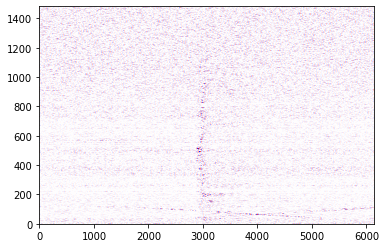

In [4]:
fs = 50.0

file = '../data/preprocessed/real_test/2023p273854.h5'
idx = 5500

with h5py.File(file, 'r') as hf:
    samples = hf['DAS'][81:,idx-3072:idx+3072]

if dx == 20:
    samples = samples[::5]

gutter = 1000
x = np.pad(samples[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)
np.save('../data/2023p273854_input{}.npy'.format(dx), x)

plt.imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

In [5]:
# Calculate CN2S reconstruction

if not os.path.isfile('../data/2023p273854_CN2S{}.npy'.format(dx)):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-finetuned{}-complement-{}x{}-{}x180_200.pt'.format(dx, nx, nt, nx_width)))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), nx, nt, nx_width, nx_stride=nx_width//2, nt_stride=180//2, batch_size=128, dx=dx, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p273854_CN2S{}.npy'.format(dx), rec_filt)

In [6]:
# Calculate N2S reconstruction

if not os.path.isfile('../data/2023p273854_N2S{}.npy'.format(dx)):

    model = models.N2SUNet(1, 1, 4).to(device)
    model.load_state_dict(torch.load('../ckpt/N2S-finetuned{}-{}x2048-{}x2048_200.pt'.format(dx, 11 + 3*11* (dx == 4), 1 + 3* (dx == 4))))
    model.eval()
    if dx == 20:
        rec = inference.channelwise_reconstruct(model, torch.from_numpy(x).to(device), nx=11, nt=2048)
    else:
        rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 44, 2048, 4, nx_stride=4, nt_stride=512, batch_size=128, dx=dx, verbose=False, ende=True)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p273854_N2S{}.npy'.format(dx), rec_filt)

In [7]:
x = np.load('../data/2023p273854_input{}.npy'.format(dx))[:,2000:4000]
cn2s = np.load('../data/2023p273854_CN2S{}.npy'.format(dx))[:,2000:4000]
n2s = np.load('../data/2023p273854_N2S{}.npy'.format(dx))[:,2000:4000]

# claculate semblance

if not os.path.isfile('../data/semblance{}x25-gain{}_input.npy'.format(60//dx, dx)):
    S = moving_window_semblance(x, size=(60//dx, 25))
    np.save('./out/semblance{}x25-gain{}_input.npy'.format(60//dx, dx), S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

if not os.path.isfile('../data/semblance{}x25-gain{}_CN2S.npy'.format(60//dx, dx)):
    S = moving_window_semblance(cn2s, size=(60//dx, 25))
    np.save('./out/semblance{}x25-gain{}_CN2S.npy'.format(60//dx, dx), S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

if not os.path.isfile('../data/semblance{}x25-gain{}_N2S.npy'.format(60//dx, dx)):
    S = moving_window_semblance(n2s, size=(60//dx, 25))
    np.save('./out/semblance{}x25-gain{}_N2S.npy'.format(60//dx, dx), S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

S_input = np.load('../data/semblance{}x25-gain{}_input.npy'.format(60//dx, dx))
S_CN2S = np.load('../data/semblance{}x25-gain{}_CN2S.npy'.format(60//dx, dx))
S_N2S = np.load('../data/semblance{}x25-gain{}_N2S.npy'.format(60//dx, dx))

if dx == 4:
    pad = 16
else:
    pad = 10
S_input = np.pad(S_input / (1-S_input), ((pad,pad),(0,0)), mode='edge')
S_CN2S = np.pad(S_CN2S / (1-S_CN2S), ((pad,pad),(0,0)), mode='edge')
S_N2S = np.pad(S_N2S / (1-S_N2S), ((pad,pad),(0,0)), mode='edge')

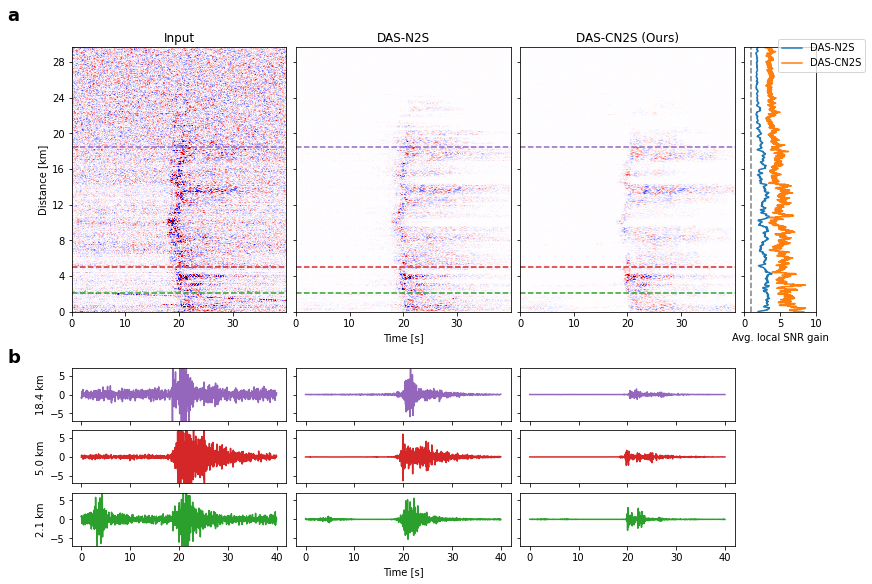

In [8]:
fig, axs = plt.subplot_mosaic([['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a1', 'a1', 'a1', 'b1', 'b1', 'b1', 'c1', 'c1', 'c1', 'd1'],
                               ['a2', 'a2', 'a2', 'b2', 'b2', 'b2', 'c2', 'c2', 'c2', 'd2'],
                               ['a3', 'a3', 'a3', 'b3', 'b3', 'b3', 'c3', 'c3', 'c3', 'd3']],
                              layout='constrained', figsize=(12,8))

v = 1
axs['a'].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
axs['a'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 0.001 * dx))}')) 

axs['b'].imshow(n2s, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
#axs['b'].set_yticklabels([])
axs['c'].imshow(cn2s, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
#axs['c'].set_yticklabels([])

ch1 = 105 * 20 // dx
ch2 = 250 * 20 // dx
ch3 = 920 * 20 // dx

for s in ['a', 'b', 'c']:
    axs[s].axhline(ch1, ls="--", c="tab:green")
    axs[s].axhline(ch2, ls="--", c="tab:red")
    axs[s].axhline(ch3, ls="--", c="tab:purple")
    
axs['a1'].plot(x[ch3], color='tab:purple')
axs['a2'].plot(x[ch2], color='tab:red')
axs['a3'].plot(x[ch1], color='tab:green')
axs['b1'].plot(n2s[ch3], color='tab:purple')
axs['b2'].plot(n2s[ch2], color='tab:red')
axs['b3'].plot(n2s[ch1], color='tab:green')
axs['c1'].plot(cn2s[ch3], color='tab:purple')
axs['c2'].plot(cn2s[ch2], color='tab:red')
axs['c3'].plot(cn2s[ch1], color='tab:green')

axs['a1'].set_ylabel("{:.1f} km".format(ch3*dx / 1000))
axs['a2'].set_ylabel("{:.1f} km".format(ch2*dx / 1000))
axs['a3'].set_ylabel("{:.1f} km".format(ch1*dx / 1000))

for s in ['a', 'b', 'c', 'a1', 'b1', 'c1', 'a2', 'b2', 'c2', 'a3', 'b3', 'c3']:
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) / 50))}'))
for s in ['a1', 'b1', 'c1', 'a2', 'b2', 'c2']:
    axs[s].set_xticklabels([])
for s in ['b1', 'b2', 'b3', 'c1', 'c2', 'c3']:
    axs[s].set_yticklabels([])    

for s in ['a1', 'a2', 'a3']:
    axs[s].set_ylim((-7,7))
for s in ['b1', 'b2', 'b3']:
    axs[s].set_ylim((-7,7))
for s in ['c1', 'c2', 'c3']:
    axs[s].set_ylim((-7,7))

axs['d1'].axis('off')
axs['d2'].axis('off')
axs['d3'].axis('off')

axs['a'].set_ylabel('Distance [km]')

axs['b'].set_xlabel('Time [s]')
axs['b3'].set_xlabel('Time [s]')
axs['b'].set_yticklabels([])
axs['c'].set_yticklabels([])
axs['d'].set_yticklabels([])

axs['a'].set_title('Input')
axs['b'].set_title('DAS-N2S')
axs['c'].set_title('DAS-CN2S (Ours)')

f1 = np.mean(S_N2S / S_input, axis=-1)
f2 = np.mean(S_CN2S / S_input, axis=-1)

if dx == 4:
    f1 = np.convolve(f1, np.ones(pad)/pad, mode='same')[pad-7:-(pad-7)]
    f2 = np.convolve(f2, np.ones(pad)/pad, mode='same')[pad-7:-(pad-7)]
else:
    f1 = np.convolve(f1, np.ones(pad)/pad, mode='same')[pad-1:-(pad-1)]
    f2 = np.convolve(f2, np.ones(pad)/pad, mode='same')[pad-1:-(pad-1)]

axs['d'].axvline(1, ls="--", c="gray")
axs['d'].plot(f1, np.arange(x.shape[0]), c="tab:blue", label='DAS-N2S')
axs['d'].plot(f2, np.arange(x.shape[0]), c="tab:orange", label='DAS-CN2S')
axs['d'].set_xlim((0, 10))
axs['d'].set_ylim((0, x.shape[0]))
axs['d'].set_xlabel('Avg. local SNR gain')
axs['d'].legend(bbox_to_anchor=(0.4, 1.05))


axs['a'].text(-0.3, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['a1'].text(-0.3, 1.1, 'b', transform=axs['a1'].transAxes, size=18, weight='bold')

if dx == 20:
    plt.savefig('./out/figure_10.pdf', bbox_inches='tight', dpi=200)
else:
    plt.savefig('./out/figure_11.pdf', bbox_inches='tight', dpi=200)
plt.show()